# **Part A**
Count / Frequency based Naive Bayes Classifier

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# TODOs completed below
# =======================================================


# Data loading function (DO NOT CHANGE)
def load_pubmed_rct_file(filepath):
    """
    Reads a .txt file from the PubMed 20k RCT dataset.
    Returns a DataFrame with 'label' and 'sentence'.
    """
    labels, sentences = [], []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '\t' not in line:
                continue
            label, sent = line.split('\t', maxsplit=1)
            labels.append(label)
            sentences.append(sent)
    return pd.DataFrame({'label': labels, 'sentence': sentences})


# Implementing Multinomial Naive Bayes from scratch
class NaiveBayesClassifier:
    """
    Multinomial Naive Bayes Classifier implemented from scratch.
    It is suitable for both Count and TF-IDF features.
    """
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_log_probs = {}
        self.classes = None
        self.vocabulary_size = 0

    def fit(self, X_counts, y):
        y_array = y.to_numpy()
        self.classes = np.unique(y_array)
        self.vocabulary_size = X_counts.shape[1]

        for c in self.classes:
            X_c = X_counts[y_array == c]


            self.class_priors[c] = np.log(X_c.shape[0] / X_counts.shape[0])

            feature_sum = X_c.sum(axis=0).A1
            total_mass = np.sum(feature_sum)

            numerator = feature_sum + self.alpha

            denominator = total_mass + self.alpha * self.vocabulary_size


            self.feature_log_probs[c] = np.log(numerator / denominator)

    def predict(self, X_counts):
        y_pred = []
        for i in range(X_counts.shape[0]):
            scores = {}
            x_i = X_counts.getrow(i)

            for c in self.classes:
                log_prob = self.class_priors[c]
                log_likelihoods = self.feature_log_probs[c]

                non_zero_indices = x_i.indices
                non_zero_data = x_i.data

                log_prob += np.sum(non_zero_data * log_likelihoods[non_zero_indices])
                scores[c] = log_prob

            predicted_class = max(scores, key=scores.get)

            y_pred.append(predicted_class)


        return np.array(y_pred)


In [2]:
from google.colab import files
uploaded = files.upload()


Saving dev.txt to dev.txt
Saving test.txt to test.txt
Saving train.txt to train.txt


In [3]:
import pandas as pd
import os

# Assuming your helper function is defined:
# load_pubmed_rct_file(filepath)

try:
    train_df = load_pubmed_rct_file('train.txt')
    dev_df   = load_pubmed_rct_file('dev.txt')
    test_df  = load_pubmed_rct_file('test.txt')

    print(f"Train samples: {len(train_df)}")
    print(f"Dev   samples: {len(dev_df)}")
    print(f"Test  samples: {len(test_df)}")

    X_train, y_train = train_df['sentence'], train_df['label']
    X_dev,   y_dev   = dev_df['sentence'],   dev_df['label']
    X_test,  y_test  = test_df['sentence'],  test_df['label']
    target_names = sorted(y_train.unique())
    print(f"Classes: {target_names}")

except FileNotFoundError:
    print("Error: Dataset file not found in /content/. Make sure you uploaded all three files.")
    X_train, y_train = pd.Series([]), pd.Series([])
    X_test, y_test = pd.Series([]), pd.Series([])
    target_names = []


Train samples: 180040
Dev   samples: 30212
Test  samples: 30135
Classes: ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']


In [ ]:
# Feature Extraction and Custom Model Training
if X_train is not None and len(X_train) > 0:

    count_vectorizer = CountVectorizer(
        lowercase=True,
        strip_accents='unicode',
        stop_words='english',
        ngram_range=(1, 2),
        min_df=1
    )

    print("Fitting Count Vectorizer and transforming training data...")
    X_train_counts = count_vectorizer.fit_transform(X_train.astype(str))
    if X_train_counts is not None:
        print(f"Vocabulary size: {X_train_counts.shape[1]}")

    print("Transforming test data...")
    X_test_counts = count_vectorizer.transform(X_test.astype(str))

    print("\nTraining the Custom Naive Bayes Classifier (from scratch)...")
    nb_model = NaiveBayesClassifier(alpha=1.0)
    nb_model.fit(X_train_counts, y_train)
    print("Training complete.")

else:
    print("Skipping feature extraction and training: Training data is empty or not loaded.")


Fitting Count Vectorizer and transforming training data...
Vocabulary size: 1108611
Transforming test data...

Training the Custom Naive Bayes Classifier (from scratch)...
Training complete.


In [ ]:
# Predict and evaluate on test set
print("\n=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===")

y_test_counts = count_vectorizer.transform(X_test)
y_test_pred = nb_model.predict(y_test_counts)

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    print(f"Macro-averaged F1 score: {test_f1:.4f}")
else:
    print("Prediction step failed or incomplete.")



=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===
Accuracy: 0.7431
              precision    recall  f1-score   support

  BACKGROUND       0.61      0.46      0.53      3621
 CONCLUSIONS       0.65      0.62      0.63      4571
     METHODS       0.74      0.91      0.82      9897
   OBJECTIVE       0.67      0.29      0.41      2333
     RESULTS       0.83      0.84      0.84      9713

    accuracy                           0.74     30135
   macro avg       0.70      0.63      0.64     30135
weighted avg       0.74      0.74      0.73     30135

Macro-averaged F1 score: 0.6446


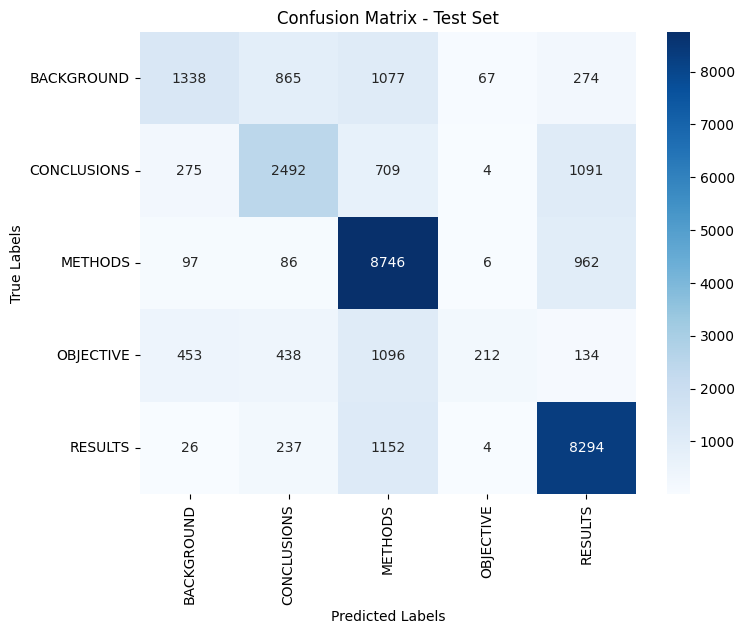

In [ ]:
# Confusion Matrix on test set
if y_test_pred is not None:
    cm = confusion_matrix(y_test, y_test_pred, labels=target_names)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix - Test Set")
    plt.show()
else:
    print("Cannot display confusion matrix: no predictions available.")


# **Part B**
TF-IDF score based Classifier

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# TODO: Implement the following steps:
# 1. Define the initial `pipeline` combining TfidfVectorizer and MultinomialNB with default parameters.
# 2. Train the initial pipeline on the training data (X_train, y_train).
# 3. Predict and evaluate the performance of the initial model on the test data (X_test, y_test).
# 4. Define the `param_grid` for hyperparameter tuning.
# 5. Initialize `GridSearchCV` using the pipeline, parameter grid, and appropriate cross-validation settings.
# 6. Fit the Grid Search object using the development data (X_dev, y_dev).
# 7. Print the `best_params_` and `best_score_` found by the grid search.
# =======================================================

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

print("Training initial Naive Bayes pipeline...")
pipeline.fit(X_train, y_train)
print("Training complete.")

print("\n=== Test Set Evaluation (Initial Sklearn Model) ===")
y_test_pred = pipeline.predict(X_test)
if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    print(f"Macro-averaged F1 score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
else:
    print("Initial model evaluation skipped: Predictions not available.")

param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'nb__alpha': [0.1, 0.5, 1.0]
}

if len(y_dev) >= 2:
    grid = GridSearchCV(pipeline, param_grid, cv=2, scoring='f1_macro')
    print("\nStarting Hyperparameter Tuning on Development Set...")
    grid.fit(X_dev, y_dev)
    print("Grid search complete.")

    if hasattr(grid, 'best_params_'):
        print("\nBest Parameters Found:")
        print(grid.best_params_)
        print(f"Best Cross-Validation F1 Score: {grid.best_score_:.4f}")
else:
    print("Skipping hyperparameter tuning: not enough samples in development set.")


Training initial Naive Bayes pipeline...
Training complete.

=== Test Set Evaluation (Initial Sklearn Model) ===
Accuracy: 0.6996
              precision    recall  f1-score   support

  BACKGROUND       0.61      0.37      0.46      3621
 CONCLUSIONS       0.61      0.55      0.57      4571
     METHODS       0.68      0.88      0.77      9897
   OBJECTIVE       0.72      0.09      0.16      2333
     RESULTS       0.77      0.85      0.81      9713

    accuracy                           0.70     30135
   macro avg       0.68      0.55      0.56     30135
weighted avg       0.69      0.70      0.67     30135

Macro-averaged F1 score: 0.5555

Starting Hyperparameter Tuning on Development Set...
Grid search complete.

Best Parameters Found:
{'nb__alpha': 0.1, 'tfidf__ngram_range': (1, 1)}
Best Cross-Validation F1 Score: 0.5897


# **Part C**
Bayes Optimal Classifier

Part C Draft

Please enter your full SRN (e.g., PES1UG22CS345): PES2UG23CS186
Using dynamic sample size: 10186
Actual sampled training set size used: 10186

Training all base models...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


All base models trained.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Fitting the VotingClassifier (BOC approximation)...
Fitting complete.

Predicting on test set...

=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===
              precision    recall  f1-score   support

  BACKGROUND       0.56      0.34      0.42      3621
 CONCLUSIONS       0.59      0.55      0.57      4571
     METHODS       0.70      0.89      0.78      9897
   OBJECTIVE       0.67      0.35      0.46      2333
     RESULTS       0.79      0.81      0.80      9713

    accuracy                           0.70     30135
   macro avg       0.66      0.59      0.61     30135
weighted avg       0.69      0.70      0.69     30135



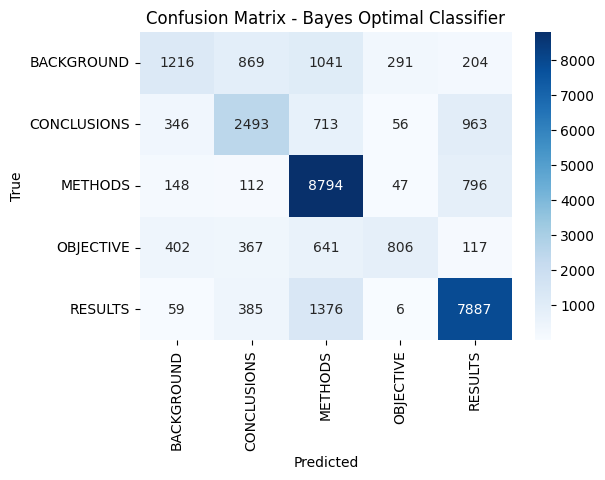

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

BASE_SAMPLE_SIZE = 10000
FULL_SRN = input("Please enter your full SRN (e.g., PES1UG22CS345): ")

try:
    if len(FULL_SRN) >= 3:
        srn_suffix_str = FULL_SRN[-3:]
        srn_value = int(srn_suffix_str)
    else:
        raise ValueError("SRN too short.")
except (ValueError, IndexError, TypeError):
    print("WARNING: SRN input failed or format is incorrect. Using 10000.")
    srn_value = 0

SAMPLE_SIZE = BASE_SAMPLE_SIZE + srn_value
print(f"Using dynamic sample size: {SAMPLE_SIZE}")

if 'X_train' not in locals() or len(X_train) == 0:
    print("Warning: Training data not found. Using small placeholder data.")
    X_train = pd.Series(["sample text one"] * 11000)
    y_train = pd.Series(["BACKGROUND"] * 5000 + ["METHODS"] * 6000)
    X_test = pd.Series(["test text one", "test text two"])
    y_test = pd.Series(["BACKGROUND", "METHODS"])
    target_names = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]

effective_sample_size = min(SAMPLE_SIZE, len(X_train))
X_train_sampled = X_train[:effective_sample_size]
y_train_sampled = y_train[:effective_sample_size]
print(f"Actual sampled training set size used: {effective_sample_size}")

tfidf_params = {
    'lowercase': True,
    'strip_accents': 'unicode',
    'stop_words': 'english',
    'ngram_range': (1, 1),
    'min_df': 5
}

h1_nb = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', MultinomialNB(alpha=1.0, fit_prior=False))
])

h2_lr = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42))
])

h3_rf = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1), cv=3, method='isotonic'
    ))
])

h4_dt = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        DecisionTreeClassifier(max_depth=10, random_state=42), cv=3, method='isotonic'
    ))
])

h5_knn = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        KNeighborsClassifier(n_neighbors=5, n_jobs=-1), cv=3, method='isotonic'
    ))
])

hypotheses = [h1_nb, h2_lr, h3_rf, h4_dt, h5_knn]
hypothesis_names = ['NaiveBayes', 'LogisticRegression', 'RandomForest', 'DecisionTree', 'KNN']

print("\nTraining all base models...")
for model in hypotheses:
    model.fit(X_train_sampled, y_train_sampled)
print("All base models trained.")

X_sub_train, X_val, y_sub_train, y_val = train_test_split(X_train_sampled, y_train_sampled, test_size=0.2, random_state=42)
val_scores = []
for model in hypotheses:
    model.fit(X_sub_train, y_sub_train)
    preds = model.predict(X_val)
    val_scores.append(f1_score(y_val, preds, average='macro'))

posterior_weights = np.array(val_scores) / np.sum(val_scores)

estimators = list(zip(hypothesis_names, hypotheses))
boc_soft_voter = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=posterior_weights,
    n_jobs=-1
)

print("\nFitting the VotingClassifier (BOC approximation)...")
boc_soft_voter.fit(X_train_sampled, y_train_sampled)
print("Fitting complete.")

print("\nPredicting on test set...")
y_pred = boc_soft_voter.predict(X_test)

print("\n=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===")
if y_pred is not None:
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Bayes Optimal Classifier')
    plt.show()
else:
    print("Evaluation skipped: Predictions not generated.")
